Basic Usage
===========

This example covers the typical workflow for Gaussian beam mode matching. This usually consists of fitting the initial beam to measured data, setting up the mode matching problem in terms of the desired shifting ranges and lenses to use and finally evaluating the candidate solutions.

Beam Characterization
---------------------

We start by characterizing the input beam. Let's assume that we have made a few beam diameter measurements at different z-coordinates along the beam. We can construct :class:`~corset.core.Beam` objects by fitting the measured data. Make sure to use the correct quantities and units. Beam corset describes Gaussian beams by their $1/e$ **radius** in amplitude which is equivalent to the $1/e^2$ radius in intensity, this is as opposed to many beam profilers which report the beam size as $1/e^2$ **diameter** in intensity. To preempt any kind of confusion, Beam corset uses meters for all units of length. We invoke the fit using the beam's :meth:`~corset.core.Beam.fit` class method.

Here we just write the data to NumPy arrays but in practice you would probably want to read them from a CSV file using Pandas' :func:`pandas.read_csv` function or similar.

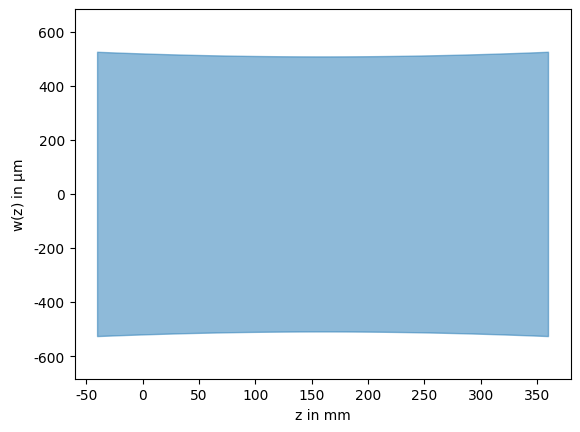

In [2]:
from corset import Beam
import numpy as np

positions = np.array([0, 10, 20, 30, 40, 50]) * 1e-2
diameters = np.array([1024, 1029, 1026, 1020, 1106, 1084]) * 1e-6

initial_beam = Beam.fit(zs=positions, rs=diameters / 2, wavelength=1064e-9)
initial_beam

Since the :class:`~corset.core.Beam` class has a PNG representation, the beam will be visualized if we put it as the last expression in a Jupyter notebook cell.

To verify that the fit is reasonable we can also explicitly explicitly plot the beam and then add the measured data points. While the beam is internally represented using a complex beam parameter, the fit parameters are still accessible as properties of the object.

Fitted waist: 508.66 µm @ z=15.96 cm


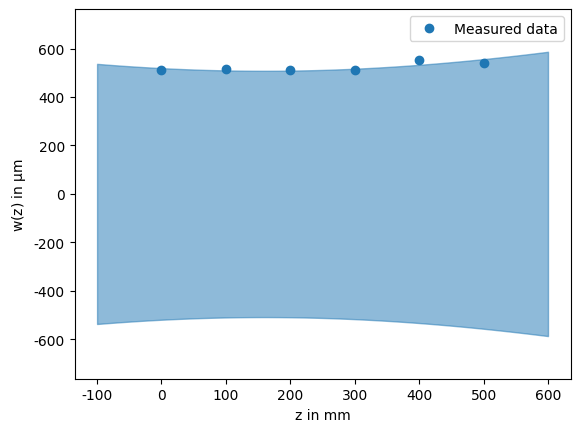

In [3]:
import matplotlib.pyplot as plt

initial_beam.plot(limits=(-0.1, 0.6))
plt.plot(positions, diameters / 2, 'o', label='Measured data')
plt.legend()
print(f"Fitted waist: {initial_beam.waist*1e6:.2f} µm @ z={initial_beam.focus*100:.2f} cm")

Mode Matching Setup
-------------------

To setup the mode matching problem we need to specify at least four things:

- The initial beam (we have already done this above)
- The desired beam
- A set of lenses to be used for mode matching
- At least one shifting range where the lenses can be placed

The desired beam is another :class:`~corset.core.Beam` object just like the initial beam. However, instead of fitting it we will create it from a waist size and location using the :meth:`~corset.core.Beam.from_gauss` class method.

In [4]:
desired_beam = Beam.from_gauss(focus=1.0, waist=100e-6, wavelength=initial_beam.wavelength)

Next, we specify the set of lenses, which are modeled using :class:`~corset.core.Lens` objects. In the simplest case these are :class:`~corset.core.ThinLens` objects with no physical thickness that needs to be accounted for when shifting. In practice you would want to setup a library of lenses the represent the physical lenses available to you. When creating lenses, we can also specify left and right margins which can be thought of as collision boxes that prevent the lenses from being placed too close to other optical elements. If we do not specify any margins, they will default to zero.

We will create two lenses with focal lengths of $f = 100\text{ mm}$ and $f = 150\text{ mm}$ respectively. The solver may use each of them for as often as necessary, or in this case two since we are only searching for two-lens solutions.

In [5]:
from corset import ThinLens

lenses = [
    ThinLens(focal_length=100e-3),  # margins are optional
    ThinLens(focal_length=150e-3, left_margin=10e-3, right_margin=10e-3),
]

Finally, we create the shifting range where the lenses can be placed, these are modeled as :class:`~corset.solver.ShiftingRange` objects. They are specified by a "left" starting coordinate and a "right" ending coordinate.

In [ ]:
from corset import ShiftingRange

shifting_range = ShiftingRange(left=0., right=0.8)

With everything setup, we can perform the mode matching. For this we also need to specify the maximum number of lenses to use, we choose two as this should provide enough degrees of freedom for a perfect mode overlap. By default the function will only return solutions with greater than $99.9\text{ \%}$ mode overlap meaning only "perfect" solutions while allowing for some numerical error.

In [ ]:
from corset import mode_match

solutions = mode_match(
    setup=initial_beam,
    desired_beam=desired_beam,
    ranges=[shifting_range],
    selection=lenses,
    min_elements=1,
    max_elements=2,
)
print(f"Found {len(solutions)} solutions")

Found 3 solutions


Evaluating Solutions
--------------------

The solver found three solutions, which by our specification all have approximately 100% mode overlap. The result of the :func:`~corset.solver.mode_match` call is a :class:`~corset.solver.SolutionList` list which provides an overview of various properties of the solutions found and allows for filtering and sorting by any of these quantities. More on what they mean and how they are calculated is described in :class:`~corset.analysis.ModeMatchingAnalysis`.

The solution list as an HTML representation based on a :class:`pandas.DataFrame` which we can display by simply putting it as the last expression in a Jupyter notebook cell.

In [8]:
solutions

SolutionList(solutions=[ModeMatchingSolution(candidate=ModeMatchingCandidate(problem=ModeMatchingProblem(setup=OpticalSetup(initial_beam=Beam(beam_parameter=0.7639349642029172j, z_offset=np.float64(0.1595967309796997), wavelength=1.064e-06, gauss_cov=array([[1.47896933e-03, 1.00247847e-07],
       [1.00247847e-07, 4.42253361e-11]])), elements=[]), desired_beam=Beam(beam_parameter=0.029526246744264968j, z_offset=1.0, wavelength=1.064e-06, gauss_cov=None), ranges=[ShiftingRange(left=0.0, right=0.8, min_elements=0, max_elements=inf, selection=[])], selection=[ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None), ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None)], min_elements=1, max_elements=2, constraints=[], rng=Generator(PCG64) at 0x211368357E0), populations=[(ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None), ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None))]), overlap=np.float64(0.9999996470368111), positions=array([0.48016728, 0.74649743])), ModeMatchingSolution(candidate=ModeMatchingCandidate(problem=ModeMatchingProblem(setup=OpticalSetup(initial_beam=Beam(beam_parameter=0.7639349642029172j, z_offset=np.float64(0.1595967309796997), wavelength=1.064e-06, gauss_cov=array([[1.47896933e-03, 1.00247847e-07],
       [1.00247847e-07, 4.42253361e-11]])), elements=[]), desired_beam=Beam(beam_parameter=0.029526246744264968j, z_offset=1.0, wavelength=1.064e-06, gauss_cov=None), ranges=[ShiftingRange(left=0.0, right=0.8, min_elements=0, max_elements=inf, selection=[])], selection=[ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None), ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None)], min_elements=1, max_elements=2, constraints=[], rng=Generator(PCG64) at 0x211368357E0), populations=[(ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None), ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None))]), overlap=np.float64(0.999999999805493), positions=array([0.27730887, 0.62659951])), ModeMatchingSolution(candidate=ModeMatchingCandidate(problem=ModeMatchingProblem(setup=OpticalSetup(initial_beam=Beam(beam_parameter=0.7639349642029172j, z_offset=np.float64(0.1595967309796997), wavelength=1.064e-06, gauss_cov=array([[1.47896933e-03, 1.00247847e-07],
       [1.00247847e-07, 4.42253361e-11]])), elements=[]), desired_beam=Beam(beam_parameter=0.029526246744264968j, z_offset=1.0, wavelength=1.064e-06, gauss_cov=None), ranges=[ShiftingRange(left=0.0, right=0.8, min_elements=0, max_elements=inf, selection=[])], selection=[ThinLens(focal_length=0.1, left_margin=0, right_margin=0, name=None), ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None)], min_elements=1, max_elements=2, constraints=[], rng=Generator(PCG64) at 0x211368357E0), populations=[(ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None), ThinLens(focal_length=0.15, left_margin=0.01, right_margin=0.01, name=None))]), overlap=np.float64(0.9999999523803363), positions=array([0.25782226, 0.70243754]))])

The solutions themselves also have a PNG representation which in addition to a plot of the setup, also includes two analysis plots, the reachability analysis and the sensitivity analysis.

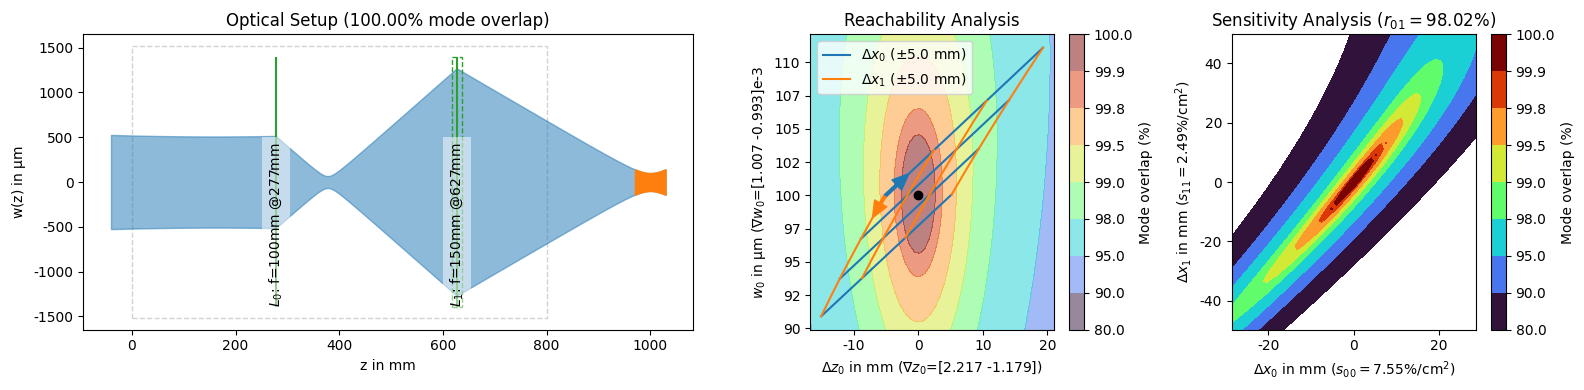

In [9]:
solutions[1]

The setup plot shows how the beam in light blue propagates through the lenses and how it overlaps with the desired beam in orange. We can also see the specified shifting range as a gray dashed box. The lenses are annotated with their name and position. If they have no name, the focal length is displayed instead. We can also see the physical margins of the $f=150\text{ mm}$ lens as a green dashed box.

The reachability analysis shows how we could change the final beams waist radius and location by displacing the lenses around their optimal positions. The sensitivity analysis shows how the mode overlap is reduced if the lens positions deviate from their optimal positions.

We can use IPython's :func:`~IPython.display.display` function to display all three solutions at once so we can compare them more easily.

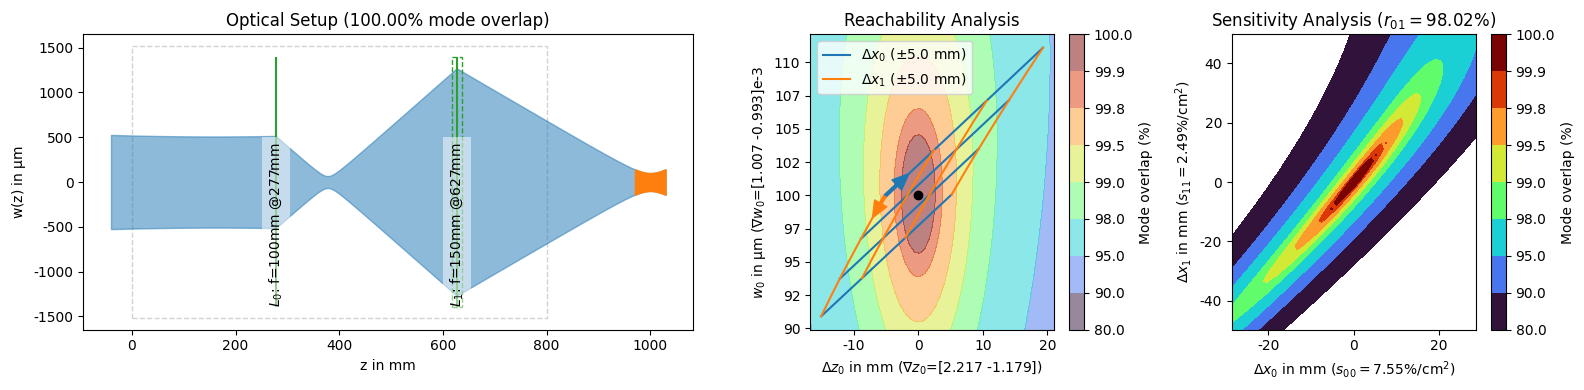

In [10]:
from IPython.display import display

display(*solutions)

While in theory, all solutions which produce the same 100% mode overlap should be equivalent, in practice, they differ significantly in how easy they are to set up and adjust in the lab. There are a lot of things what play into how hard this is, but the two most important quantities (from the ones we can calculate here) are the sensitivity of the individual degrees of freedom and how strongly they are coupled.

In both regards, the third solution is significantly better than the first two. The sensitivity describes, how much mode overlap we lose per distance (squared) moved. For the third solution this is $1.57\text{ \%/cm}^2$ and $0.22\text{ \%/cm}^2$ for the two lenses respectively. This means that if everything else is correct and we displace the first lens by $1\text{ cm}$ (which we have to square to $1\text{ cm}^2$), we lose about $1.57\text{ \%}$ mode overlap. For the other two solutions, the loss in overlap is much larger for such a displacement.

The second quantity, the coupling, describes how well we can adjust the lenses independently to improve the mode overlap, where lower coupling is better. If this coupling is high, we can not get a significant improvement in mode overlap by just moving one lens at a time, so we either have to move them together, or alternate many times between them to get a significant improvement, both of which are difficult to do in practice.

Somewhat related to these quantities is how independently the two degrees of freedom change the resulting waist size and location. We can see this in the reachability plot where the third solution is also the best, the first lens mostly changes the waist location while the second lens mostly changes the waist size.